# Logistic Regression

Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

It works very much the same way Linear Regression does, except that the optimization function is not OLS but [_maximum likelihood_](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

## Important considerations

- We use logistic regression to train a model to predict between 2-classes: Yes/No, Black/White, True/False. If we need to predict more than two classes, we need to build some artifacts in logistic regression that will be explained at the end of this notebook.
- No dependent variables should be among the set of features. Study the correlation between all the features separatedly.
- Scaled, norm'd and centered input variables.

The output from a logistic regression is always the log of the odds. We will explore this concept further along the exercise.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [16]:
data = pd.read_csv('train_complete_prepared.csv')
data.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LotFrontage
0,8,60,RL,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,Shed,350,11,2009,WD,Normal,200000,80.115468
1,51,60,RL,13869,Pave,NaN,IR2,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,7,2007,WD,Normal,177000,76.703758
2,112,80,RL,7750,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,4,2010,WD,Normal,180000,67.285313
3,148,60,RL,9505,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,NaN,NaN,NaN,0,5,2010,WD,Normal,222500,69.803112
4,178,50,RL,13650,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,7,2006,WD,Normal,172500,75.799522


Lets build a dataframe that will contain the type and number of NAs that each feature contains. We will use it to decide what variables to select. We will now from there what features are numerical and categorical, and how many contain NAs.

In [17]:
def dataframe_metainformation(df):
    meta = dict()
    descr = pd.DataFrame({'dtype': df.dtypes, 'NAs': df.isna().sum()})
    categorical_features = descr.loc[descr['dtype'] == 'object'].index.values.tolist()
    numerical_features = descr.loc[descr['dtype'] != 'object'].index.values.tolist()
    numerical_features_na = descr.loc[(descr['dtype'] != 'object') & (descr['NAs'] > 0)].index.values.tolist()
    categorical_features_na = descr.loc[(descr['dtype'] == 'object') & (descr['NAs'] > 0)].index.values.tolist()
    complete_features = descr.loc[descr['NAs'] == 0].index.values.tolist()
    meta['description'] = descr
    meta['categorical_features'] = categorical_features
    meta['categorical_features'] = categorical_features
    meta['categorical_features_na'] = categorical_features_na
    meta['numerical_features'] = numerical_features
    meta['numerical_features_na'] = numerical_features_na
    meta['complete_features'] = complete_features
    return meta

def print_metainformation(meta):
    print('Available types:', meta['description']['dtype'].unique())
    print('{} Features'.format(meta['description'].shape[0]))
    print('{} categorical features'.format(len(meta['categorical_features'])))
    print('{} numerical features'.format(len(meta['numerical_features'])))
    print('{} categorical features with NAs'.format(len(meta['categorical_features_na'])))
    print('{} numerical features with NAs'.format(len(meta['numerical_features_na'])))
    print('{} Complete features'.format(len(meta['complete_features'])))

meta = dataframe_metainformation(data)
print_metainformation(meta)

Available types: [dtype('int64') dtype('O') dtype('float64')]
80 Features
43 categorical features
37 numerical features
16 categorical features with NAs
0 numerical features with NAs
64 Complete features


Can we build a model that will predict the contents of one of those categorical columns with NAs? Let's try! I will start with `FireplaceQu` that presents a decent amount of NAs.

Define **target** and **features** to hold the variable we want to predict and the features I can use (those with no NAs). We remove the `Id` from the list of features to be used by our model. Finally, we establish what is the source dataset, by using only those rows from `data` that are not equal to NA.

Lastly, we will encode all categorical features (but the target) to have a proper setup for running the logistic regression. To encode, we'll use OneHotEncoding by calling `get_dummies`. The resulting dataset will have all numerical features.

In [18]:
target = 'FireplaceQu'
features = meta['complete_features']
features.remove('Id')
print('Selecting {} features'.format(len(features)))

data_complete = data.filter(features + [target])
data_complete = data_complete[data_complete[target].notnull()]

meta_complete = dataframe_metainformation(data_complete)
print_metainformation(meta_complete)
dummy_columns = meta_complete['categorical_features']
dummy_columns.remove(target)
data_encoded = pd.get_dummies(data_complete, columns=dummy_columns)
data_encoded.head(3)

Selecting 63 features
Available types: [dtype('int64') dtype('O') dtype('float64')]
64 Features
28 categorical features
36 numerical features
0 categorical features with NAs
0 numerical features with NAs
64 Complete features


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,10382,7,6,1973,1973,240,859,32,216,...,0,0,0,0,1,0,0,0,1,0
2,80,7750,7,5,2000,2000,0,250,0,134,...,0,0,0,0,1,0,0,0,1,0
3,60,9505,7,5,2001,2001,180,0,0,884,...,0,0,0,0,1,0,0,0,1,0


How many occurences do we have from each class of the target variable?

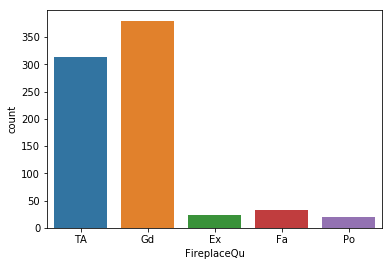

In [19]:
sns.countplot(x='FireplaceQu', data=data_encoded)

Since we've very few occurences of classes `Ex`, `Fa` and `Po`, we will remove them from the training set, and we will train our model to learn to classify only between `TA` or `Gd`.

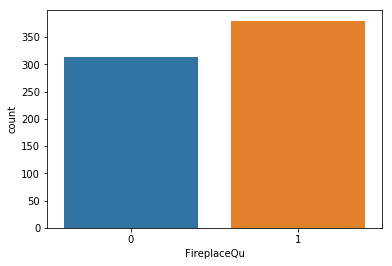

In [20]:
data_encoded = data_encoded[(data_encoded[target] != 'Ex') & 
                            (data_encoded[target] != 'Fa') & 
                            (data_encoded[target] != 'Po')]
data_encoded[target] = data_encoded[target].map({'TA':0, 'Gd':1})
sns.countplot(x='FireplaceQu', data=data_encoded);

Set the list of features prepared

In [21]:
features = list(data_encoded)
features.remove(target)

### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [22]:
from sklearn.exceptions import ConvergenceWarning
import warnings
from pprint import pprint

X = data_encoded.loc[:, features]
y = data_encoded.loc[:, target]
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

logreg = LogisticRegression(solver='lbfgs', max_iter=250)
rfe = RFE(logreg, 15)
rfe = rfe.fit(X, y)
pprint('Selected features: {}'.format(list(data_encoded.loc[:, rfe.support_])))

("Selected features: ['MSZoning_RL', 'LandContour_Bnk', "
 "'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NWAmes', "
 "'Neighborhood_NoRidge', 'Neighborhood_SawyerW', 'Neighborhood_StoneBr', "
 "'RoofStyle_Hip', 'RoofMatl_Metal', 'Exterior1st_CemntBd', "
 "'Exterior1st_MetalSd', 'Exterior2nd_Brk Cmn', 'SaleType_ConLw', "
 "'SaleCondition_Normal']")


## Building the model

In [29]:
X = data_encoded.loc[:, list(data_encoded.loc[:, rfe.support_])]
y = data_encoded.loc[:, target]

logit_model=sm.Logit(y, X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.607775
         Iterations: 35
                                   Results: Logit
Model:                     Logit                   No. Iterations:          35.0000 
Dependent Variable:        FireplaceQu             Pseudo R-squared:        0.117   
Date:                      2018-12-20 08:03        AIC:                     872.3762
No. Observations:          693                     BIC:                     940.4917
Df Model:                  14                      Log-Likelihood:          -421.19 
Df Residuals:              678                     LL-Null:                 -477.11 
Converged:                 0.0000                  Scale:                   1.0000  
------------------------------------------------------------------------------------
                      Coef.     Std.Err.      z    P>|z|      [0.025       0.975]   
------------------------------------------------------------------------------------
MSZoning_RL            0.5809     

/Users/renero/Code/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### P-Values and feature selection

Remove those predictors with _p-values_ above 0.05

Mark those features with a p-value higher thatn 0.05 (or close) to be removed from $X$, and run the logistic regression again to re-.check the p-values. From that point we'll be ready to run the model properly in sklearn.

In [24]:
to_remove = ['RoofMatl_Metal','Exterior2nd_Brk Cmn',
             'Exterior1st_MetalSd', 'SaleType_ConLw', 
             'Neighborhood_StoneBr', 'Neighborhood_Crawfor',
             'LandContour_Bnk', 'SaleCondition_Normal']
X.drop(to_remove, inplace=True, axis=1)

logit_model=sm.Logit(y, X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.619868
         Iterations 6
                           Results: Logit
Model:                 Logit             No. Iterations:    6.0000  
Dependent Variable:    FireplaceQu       Pseudo R-squared:  0.100   
Date:                  2018-12-20 07:57  AIC:               873.1368
No. Observations:      693               BIC:               904.9240
Df Model:              6                 Log-Likelihood:    -429.57 
Df Residuals:          686               LL-Null:           -477.11 
Converged:             1.0000            Scale:             1.0000  
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
MSZoning_RL           0.3556   0.1095  3.2470 0.0012  0.1409  0.5702
Neighborhood_CollgCr -0.5919   0.2902 -2.0393 0.0414 -1.1608 -0.0230
Neighborhood_NWAmes  -1.8189

### The Logit model

Here we train the model and evaluate on the test set. The interpretation of the results obtained by calling the `classification_report` are as follows:

The **precision** is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The **recall** is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The **F-beta** score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The **support** is the number of occurrences of each class in y_test.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy on test: {:.2f}'.format(logreg.score(X_test, y_test)))
cm = confusion_matrix(y_test, y_pred)
print(cm)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy on test: 0.64
[[36 63]
 [11 98]]
              precision    recall  f1-score   support

           0       0.77      0.36      0.49        99
           1       0.61      0.90      0.73       109

   micro avg       0.64      0.64      0.64       208
   macro avg       0.69      0.63      0.61       208
weighted avg       0.68      0.64      0.62       208



### ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

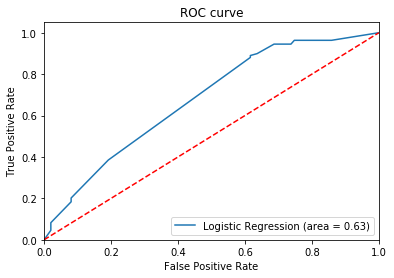

In [26]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()